# Spherical Fresnel lens

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

A spherical Fresnel lens is designed to offer the same light-focusing and magnification capabilities as a conventional spherical lens, while maintaining a slimmer and lighter profile. This lens was first conceptualized by the French physicist Augustin-Jean Fresnel in the early 19th century. Micro-sized Fresnel lenses have a vast array of potential applications, much like metalenses. They can be utilized in imaging systems, optical fibers, communication systems, and more.

This notebook showcases a 3D simulation of a Fresnel lens with a diameter and focal length of approximately 100$\lambda$. To evaluate the lens's focusing capabilities, two methods can be employed: 

1. simulating only the region close to the lens and performing a near-to-far field projection. 

2. including the focal point directly within the simulation domain. 

The most straightforward solution is to use a large simulation domain that encompasses the focal point. However, this approach is highly computationally intensive and exceeds the capabilities of most desktop-based simulation tools. Fortunately, Tidy3D facilitates the efficient execution of such comprehensive simulations. 

The geometry of the Fresnel lens appears somewhat complex. We will demonstrate how to easily construct it using only Tidy3D's geometry primitives.

<img src="img/fresnel_lens.png" width="500" alt="Schematic of the Fresnel lens">

For more lens examples such as the [metalens in the visible frequency range](https://www.flexcompute.com/tidy3d/examples/notebooks/Metalens/) and the [3D optical Luneburg lens](https://www.flexcompute.com/tidy3d/examples/notebooks/OpticalLuneburgLens/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Simulation Setup

First, we define the shape of a spherical lens from a sphere with radius $R=60$ $\mu m$. The lens is made of glass with refractive index $n=1.5$ at $\lambda$=1 $\mu m$. The lens itself has a radius of 50 $\mu m$.

In [2]:
lda0 = 1  # operation wavelength of the lens is 1 um
r = 50  # radius of the lens is set to 50 um
x = np.linspace(0, r, 1000)  
R = 60  # radius of the corresponding sphere
n = 1.5  # index of refraction of glass
O = np.sqrt(R**2-r**2)  # origin of the spherical lens
y_spherical = np.sqrt(R**2-x**2)-O   # boundary of the spherical lens

The shape of a Fresnel lens can be constructed from the spherical lens by removing layers with thickness $h =  m \lambda/(n-1)$. These layers cause a $2m\pi$ phase shift so will not impact the focusing capability of the lens. From the lens boundary profiles, we can clearly see the thickness of the Fresnel lens is much more compact compared to its spherical lens counterpart.
<img src="img/fresnel_lens_2.png" width="300">

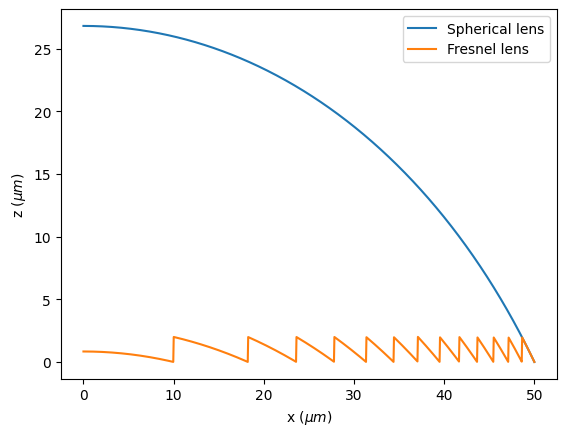

In [3]:
h = lda0/(n-1)   # fresnel lens thickness
y_fresnel = y_spherical % h   # boundary of the fresnel lens
plt.plot(x, y_spherical, x, y_fresnel)   
plt.xlabel("x ($\mu m$)")
plt.ylabel("z ($\mu m$)")
plt.legend(['Spherical lens','Fresnel lens'])
plt.show()

Smoothly curved surfaces are ideal. However, in manufacturing, the lens is often made by depositing layers of glass. Therefore, it is inevitable to discretize the surfaces. Here we discretize the surface into 10 levels, which should ensure a good lens performance while maintaining a realistic fabrication requirement. 

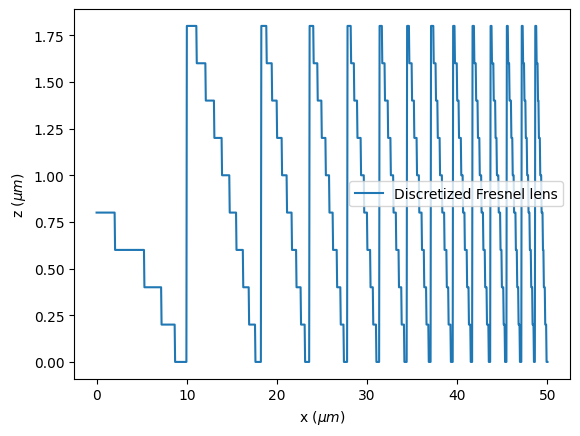

In [4]:
H = h/10  # fresnel lens discretization level
y_discretized = H*(y_fresnel // H)   # boundary of the discretized fresnel lens
plt.plot(x,y_discretized)
plt.legend(['Discretized Fresnel lens'])
plt.xlabel("x ($\mu m$)")
plt.ylabel("z ($\mu m$)")
plt.show()

Next, we will use the discretized lens profile to construct the model geometry. This is done by successively creating [Cylinders](../_autosummary/tidy3d.Cylinder.html) of glass and air with decreasing radii. Finally, a flat glass substrate is added. 

In [5]:
air = td.Medium(permittivity=1)
glass = td.Medium(permittivity=n**2)

# create the fresnel lens by using cylinders
fresnel_lens = [] 
for i in range(len(y_discretized)-1):
    if y_discretized[-i] != y_discretized[-i-1]:
        if y_discretized[-i-1] == 0:
            air_domain = td.Structure(geometry=td.Cylinder(center=(0,0,y_discretized[-i]/2), radius=x[-i], length=y_discretized[-i], axis=2),medium=air)
            fresnel_lens.append(air_domain)
        lens_domain = td.Structure(geometry=td.Cylinder(center=(0,0,y_discretized[-i-1]/2), radius=x[-i-1], length=y_discretized[-i-1], axis=2),medium=glass)
        fresnel_lens.append(lens_domain)

# create a 0.5 um thick substrate
sub_thickness = 0.5
substrate = td.Structure(geometry=td.Cylinder(center=(0,0,-sub_thickness/2), radius=max(x), length=sub_thickness, axis=2), medium=glass)
fresnel_lens.append(substrate)

Next, we set up a linearly polarized [PlaneWave](../_autosummary/tidy3d.PlaneWave.html) source and two [FieldMonitors](../_autosummary/tidy3d.FieldMonitor.html) in the $yz$ and $xz$ planes. 

In [6]:
freq0 = td.C_0/lda0  # central frequency of the source
fwidth = freq0/10  # frequency width of the source

# define a plane wave source
source_z = 3  #z position of the source
pulse = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
source = td.PlaneWave(size=(td.inf,td.inf,0), center=(0,0,source_z), source_time=pulse, direction='-')

# define a field monitor in the yz plane
field_monitor_yz = td.FieldMonitor(
    center=(0, 0, 0), 
    size=(0, td.inf, td.inf), 
    freqs=[freq0], 
    name="field_yz"
)

# define a field monitor in the xz plane
field_monitor_xz = td.FieldMonitor(
    center=(0, 0, 0), 
    size=(td.inf, 0, td.inf), 
    freqs=[freq0], 
    name="field_xz"
)

The simulation domain size is chosen to include the focal point of the lens. The simulation domain is 100 $\lambda$ by 100 $\lambda$ by 120 $\lambda$. Symmetry can be exploited to reduce the computational load.   

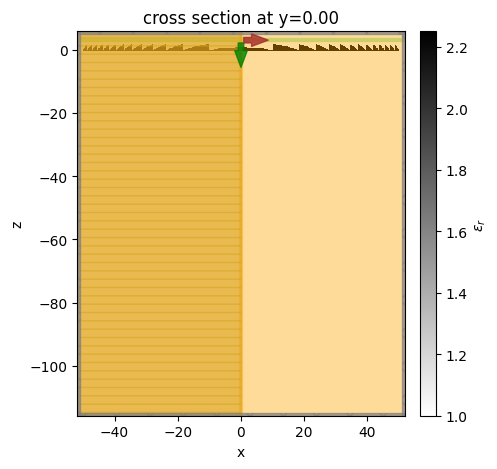

In [7]:
# define simulation domain size
buffer_xy = 2
Lz = 120
sim_size = (2*r+buffer_xy, 2*r+buffer_xy, Lz)    

# define simulation run time
run_time = 1e-12

# define simulation
offset_z = 5
sim = td.Simulation(
    center=(0,0,-Lz/2+offset_z),
    size=sim_size,
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=15),
    sources=[source],
    monitors=[field_monitor_yz, field_monitor_xz],
    structures=fresnel_lens,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(-1, 1, 0)  # symmetry is applied to reduce the computational load
    )

sim.plot_eps(y=0)
plt.show()

In [8]:
job = web.Job(simulation=sim, task_name="fresnel_lens")
estimated_cost = web.estimate_cost(job.task_id)

print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')

[19:04:41] Created task 'fresnel_lens' with task_id 'fdve-6e34f222-7ed9-49b8-a004-77ba2e8ffb30v1'.    ]8;id=705381;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=778381;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=309110;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=773611;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=188019;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e34f222-7ed9-49b8-a004-77ba2e8ffb30v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=388071;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e34f222-7ed9-49b8-a004-77ba2e8ffb30v1\taskId]8;;\]8;id=188019;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e34f222-7ed9-49b8-a004-77ba2e8ffb30v1\=]8;;\]8;id=851127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e34f222-7ed9-49b8-a004-77ba2e8ffb30v1\fdve]8;;\]8;id=188019;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e34f222-7ed9-49b8-a004-77ba2e8ffb30v1\-6e34f222-7ed9-49b8-a004-77ba2e8ffb3]8;;\              
           ]8;id=188019;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6e34f222-7ed9-49b8-a004-77ba2e8ffb30v1\0v1']8;;\.                                                                                                   

Output()

The estimated maximum cost is 10.996 Flex Credits.


Even though the simulation domain is huge, running the simulation with Tidy3D only takes mins.

In [9]:
sim_data = job.run(path="data/simulation_data.hdf5")

[19:04:45] status = queued                                                                            ]8;id=534690;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=97566;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[19:04:52] status = preprocess                                                                        ]8;id=770198;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=185014;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[19:05:11] Maximum FlexCredit cost: 10.996. Use 'web.real_cost(task_id)' to get the billed FlexCredit ]8;id=60752;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=997693;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=986477;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=140973;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=500853;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=81799;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[19:07:16] early shutoff detected, exiting.                                                           ]8;id=486652;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=905703;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=67043;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=198916;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[19:07:39] status = success                                                                           ]8;id=339951;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=218278;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[19:07:45] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=753273;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=235263;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

## Result Visualization

After the simulation is complete, we first plot the field strength distributions at the $xz$ plane and the $yz$ plane. From the plots, a nice focus is found at around $z=-102$ $\mu m$

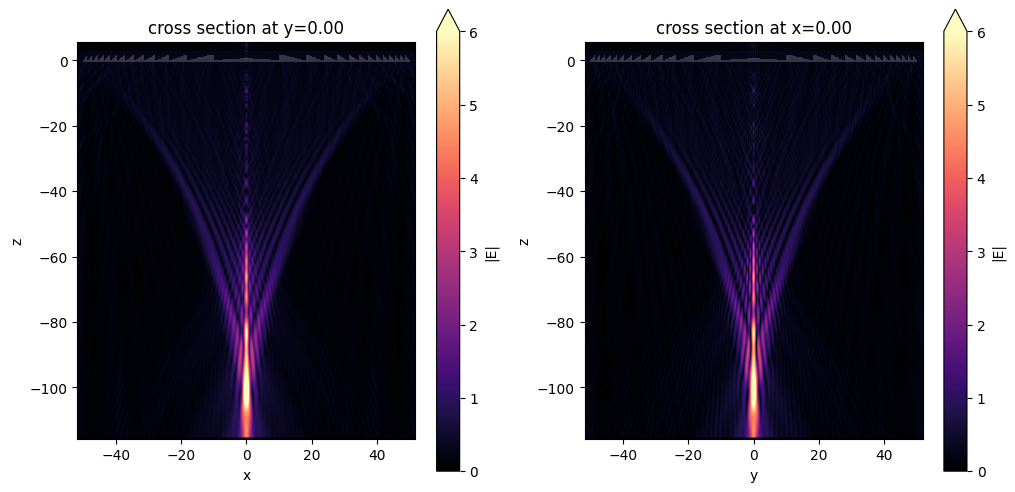

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

sim_data.plot_field(field_monitor_name='field_xz', field_name='E', val='abs', vmin=0, vmax=6, ax=ax1)
sim_data.plot_field(field_monitor_name='field_yz', field_name='E', val='abs', vmin=0, vmax=6, ax=ax2)
plt.show()

To better investigate the focusing performance, we can further plot line profiles of the field intensity distribution at the focus.

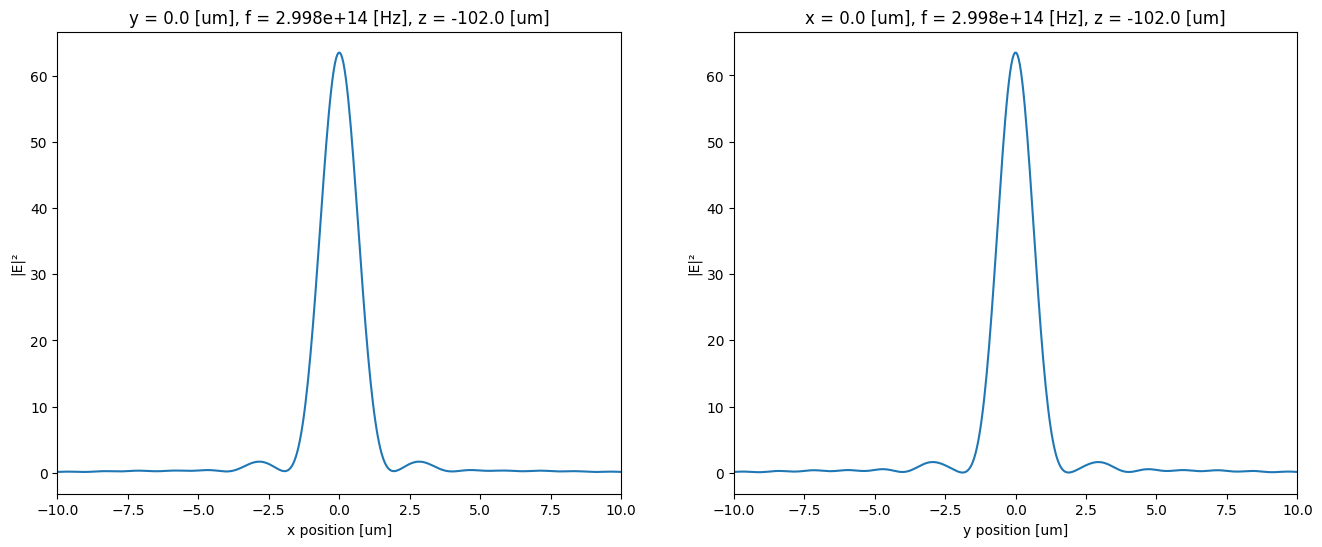

In [11]:
focal_z = -102 # z position of the focal spot

# plot field intensity at the focus
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

sim_data.get_intensity(field_monitor_name='field_xz').sel(y=0, z=focal_z, f=freq0, method='nearest').plot(ax=ax1)
ax1.set_xlim([-10,10])

sim_data.get_intensity(field_monitor_name='field_yz').sel(x=0, z=focal_z, f=freq0, method='nearest').plot(ax=ax2)
ax2.set_xlim([-10,10])
plt.show()


## Performing Near Field to Far Field Projection

Sometimes, we would like to reduce the cost of the simulation. This is when using the near field to far field projection is a valuable tool. Here as a comparison, we use a much smaller simulation domain and define a [FieldProjectionCartesianMonitor](../_autosummary/tidy3d.FieldProjectionCartesianMonitor.html) to obtain the field distribution. 

The [FieldProjectionCartesianMonitor](../_autosummary/tidy3d.FieldProjectionCartesianMonitor.html) is defined in the $xy$ plane. Note that the projection axis does not have to be perpendicular to the monitor plane. Here we show how to obtain the field distribution in the $xz$ plane by setting `proj_axis=0` and `proj_distance=0`. Since the projected distance is not large compared to the wavelength, we also disable far field approximation by setting `far_field_approx=False`. This way the projection is more accurate.

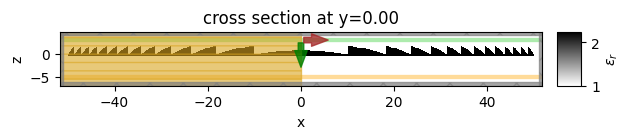

In [12]:
Lz = 10 # new simulation domain size in z
offset_z = 4

pos_monitor_z = -5 # z position of the field projection monitor

# grids of the projected field position
xs_far = np.linspace(-30,30,301) 
ys_far = np.linspace(-110,-10,301)
    
# define a field projection monitor
monitor_proj = td.FieldProjectionCartesianMonitor(
    center=[0, 0, pos_monitor_z],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="focal_plane_proj",
    proj_axis=0,  # axis along which to project, in this case x
    proj_distance=0,  # distance from this monitor to where fields are projected
    x=xs_far,
    y=ys_far,
    far_field_approx=False
)

# define a new simulation by copying the previous simulation and updating the information
sim_new = sim.copy(update={"center":(0,0,-Lz/2+offset_z),
    "size":(2*r+buffer_xy,2*r+buffer_xy,Lz),
    "monitors":[monitor_proj]})
sim_new.plot_eps(y=0)
plt.show()

Not only does this simulation costs only about 15% of the previous simulation, the simulation time is also significantly reduced. This potentially opens up the possibility of simulating a lens with an even larger radius or focal length.

After the simulation is complete, we will see if we can still obtain accurate results this way.

In [13]:
job = web.Job(simulation=sim_new, task_name="fresnel_lens_field_projection")
estimated_cost = web.estimate_cost(job.task_id)

print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')

[19:08:09] Created task 'fresnel_lens_field_projection' with task_id                                  ]8;id=777697;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=658205;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\
           'fdve-1ee98275-2581-44db-9363-5eff1284fd9cv1'.                                                          

           View task using web UI at                                                                  ]8;id=456370;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=732900;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=16733;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ee98275-2581-44db-9363-5eff1284fd9cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=660719;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ee98275-2581-44db-9363-5eff1284fd9cv1\taskId]8;;\]8;id=16733;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ee98275-2581-44db-9363-5eff1284fd9cv1\=]8;;\]8;id=529556;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ee98275-2581-44db-9363-5eff1284fd9cv1\fdve]8;;\]8;id=16733;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ee98275-2581-44db-9363-5eff1284fd9cv1\-1ee98275-2581-44db-9363-5eff1284fd9]8;;\              
           ]8;id=16733;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1ee98275-2581-44db-9363-5eff1284fd9cv1\cv1']8;;\.                                                                                                   

Output()

The estimated maximum cost is 1.979 Flex Credits.


In [14]:
sim_data_new = job.run(path="data/simulation_data.hdf5")

[19:08:13] status = queued                                                                            ]8;id=760265;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=601202;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[19:08:16] status = preprocess                                                                        ]8;id=741191;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=946571;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[19:08:34] Maximum FlexCredit cost: 1.979. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=459950;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=660097;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=548748;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=629906;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=136937;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=479278;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[19:09:41] early shutoff detected, exiting.                                                           ]8;id=769086;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=332847;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=275177;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=141889;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[19:09:44] status = success                                                                           ]8;id=558167;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=845774;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[19:09:46] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=182496;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=724214;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Plot the field distribution. Note that by default the projected field's coordinate is centered at the center of the [FieldProjectionCartesianMonitor](../_autosummary/tidy3d.FieldProjectionCartesianMonitor.html). That is, the z coordinate is offset by `pos_monitor_z`, which is 5 $\mu m$. Therefore, the focus appears at about z=-97 $\mu m$ instead of the previous -102 $\mu m$. Overall, the projected field is very close to the field simulated in the previous simulation.

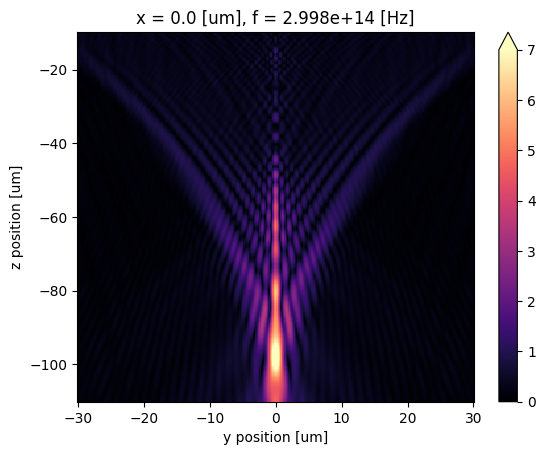

In [15]:
proj_fields = sim_data_new["focal_plane_proj"].fields_cartesian.sel(f=freq0)

# compute norm of the field
E = np.sqrt(np.abs(proj_fields.Ex)**2+np.abs(proj_fields.Ey)**2+np.abs(proj_fields.Ez)**2)

# plot field distribution
E.plot(x='y', y='z', vmin=0, vmax=7, cmap='magma')
plt.show()

Lastly, let's compare the fields at focus using the exact simulation and field projection. We can see that the projected field is nearly identical to that from a rigorous simulation.

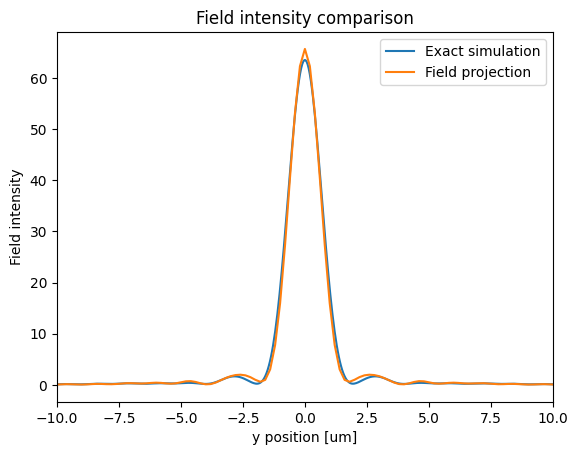

In [16]:
fig, ax = plt.subplots()

# plot field intensity at the focus from the exact simulation
sim_data.get_intensity(field_monitor_name='field_xz').sel(y=0, z=focal_z, f=freq0, method='nearest').plot(ax=ax)

# plot field intensity at the focus from the field projection
I = E**2
I.sel(z=focal_z-pos_monitor_z, method='nearest').plot(ax=ax)

# formatting the plot
ax.set_xlim([-10,10])
ax.set_title('Field intensity comparison')
ax.set_ylabel('Field intensity')
ax.legend(('Exact simulation', 'Field projection'))
plt.show()